# Numerical implementation of the elastodynamics and damage problem using dolfinx

__Authors__: A. Chao Correas (arturo.chaocorreas@polito.it) and C. Maurini (corrado.maurini@sorbonne-universite.fr)

In this notebook we will present the dolfinx implementation of the elastodynamics problem defined in the _Elastodynamics Theory_ notebook. The coding contained in this notebook is executable in parallel. To run the notebook in parallel, we are going to set up an `ipyparallel.Cluster` using `mpi` and `n` processors. In case the  `ipyparallel` library is not available in your system, you can use `!pip install ipyparallel`

In [1]:
import logging
import ipyparallel as ipp

# create a cluster
rc = ipp.Cluster(engines="mpi", n=2, log_level=logging.WARNING).start_and_connect_sync(activate=True)

  0%|          | 0/2 [00:00<?, ?engine/s]

In this notebook we will present the dolfinx implementation of the elastodynamics problem defined in the _Elastodynamics and Damage Theory_ notebook.
To do so, let us import the libraries required for running the script and set the stage. `sympy` is the only one that does not come installed in the dolfinx environment by default, so if it is not installed in the executing system, it will raise an error. To solve this, you can run `pip install sympy` beforehand for instance.

In [2]:
%%px

import dolfinx, ufl
import numpy as np
import sympy as sp
from mpi4py import MPI
from petsc4py import PETSc
from matplotlib import pyplot as plt
import sys
#import mesh_plotter

sys.path.append("../utils/")
from petsc_problems import SNESProblem

comm = MPI.COMM_WORLD

Then, we determine the input parameters of our problem which control the geometry, material, mesh, time stepping and output preferences. By defining them within dictionaries the subsequent code is more readable and the input information can be stored in a `.json` file for the record. In particular, this code will make use of a rectangular domain of size $L_{x} \times L_{y}$ centered at $(0,0)$, filled with a linear elastic material of density $\rho$ whose quasistatic behavior is defined by its Young's modulus $E$ and Poisson's ratio $\nu$. The Phase Field parameters are $G_{c}$ and $\ell$. This domain will be clamped on its left edge and have an imposed horizontal motion on the right side, so that: 

$$
\underline{u} 
= 
\dot{\underline{u}} 
= 
\ddot{\underline{u}} 
= 
\underline{0} 
\quad \forall \left\{ \underline{x}, t \mid x = -\frac{L_{x}}{2}\right\}
$$


$$
u_{x} 
= 
f(t)
= 
\left\{ 
\begin{matrix} 
0 & \mathrm{if} \quad t < T_{0} \\ 
\dot{U}\left(\sqrt{T_{0}^2+t^2}-T_0 \right) & \mathrm{if} \quad T_{0} 
\le t
\end{matrix} 
\right\},
$$
$$
\dot{u}_{x} 
= 
\dot{f}(t)
, \quad
\ddot{u}_{x}
= 
\ddot{f}(t)
\quad \forall \left\{ \underline{x}, t \mid x = \frac{L_{x}}{2}\right\}
$$


Likewise, no external force is to be considered:
$$
\underline{f} 
= 
\underline{0}
\quad \forall \left\{\underline{x},t \mid \underline{x} \in \partial_{f}\Omega\right\}
$$
$$
\underline{b} 
= 
\underline{0}
\quad \forall \left\{\underline{x},t \mid \underline{x} \in \partial_{f}\Omega\right\}
$$

In [3]:
%%px

# Characteristic dimensions of the rectangular domain
geometry_parameters = {'Lx': 1., 
                       'Ly': 0.1}

# Regularization length               
material_properties = {'E':   3e3, 
                       'nu':  0.3, 
                       'rho': 1.8e-9,
                       'Gc':  0.4,
                       'ell': 0.1,
                       'c1': 5e-7,
                       'c2': 5e-7}

# Mesh control
mesh_parameters = {'nx': 40,
                   'ny': 4}

# AltMin control
AltMin_parameters = {"max_iter": 200,
                     "alpha_L2_tol": 1e-7}

# Time stepping control
timestepping_parameters = {'initial_time': 0., 
                           'total_time':   40e-6, 
                           'delta_t':      1.e-8}

# Time integration control (Newmark's \beta-method)
timeintegration_parameters = {'beta': 0.25,
                              'gamma': 0.5}

# Output parameters
OTP_settings = {'xdmf_filename': f"implicit_elastodynamics_damage.xdmf"}

# Top facet displacement
T_0 = 2e-6
U_p = 1e3

t_sp = sp.Symbol('t', real = True)

U_imp = sp.Piecewise((0, t_sp<0),
                     (U_p*(sp.sqrt(T_0**2+t_sp**2)-T_0), True))

V_imp = sp.diff(U_imp, t_sp)
A_imp = sp.diff(V_imp, t_sp)

# Body forces
b_ = np.asarray([0.,0.])

As seen, using the symbolic math library `sympy` to define the imposed motion in the right facet results convenient for the differentiation w.r.t. time is automatically handled.

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

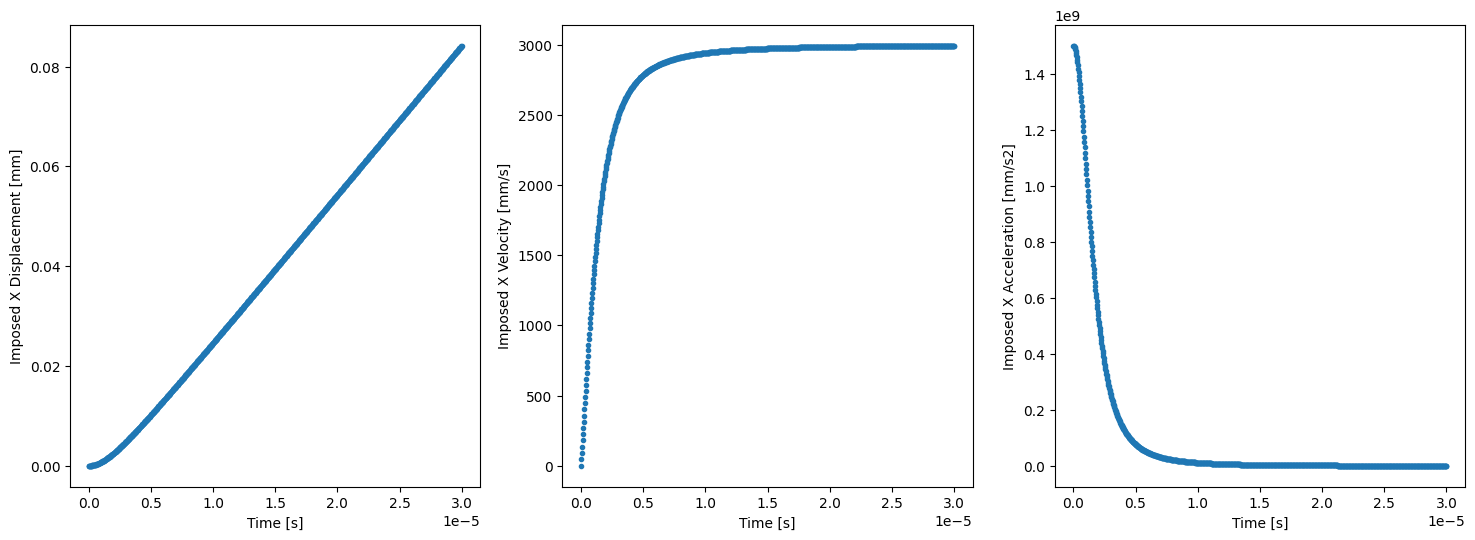

In [4]:
%%px

if comm.rank == 0:
    t_sampling = np.linspace(timestepping_parameters['initial_time'], 
                             timestepping_parameters['total_time'], 
                             1000) 
    U_imp_sampling = np.zeros_like(t_sampling)
    V_imp_sampling = np.zeros_like(t_sampling)
    A_imp_sampling = np.zeros_like(t_sampling)
    
    for i in enumerate (t_sampling):
        U_imp_sampling[i[0]] = U_imp.subs({t_sp:t_sampling[i[0]]})
        V_imp_sampling[i[0]] = V_imp.subs({t_sp:t_sampling[i[0]]})
        A_imp_sampling[i[0]] = A_imp.subs({t_sp:t_sampling[i[0]]})
        
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    ax[0].plot(t_sampling, U_imp_sampling, ls='none', marker='.')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Imposed X Displacement [mm]')
    ax[1].plot(t_sampling, V_imp_sampling, ls='none', marker='.')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Imposed X Velocity [mm/s]')
    ax[2].plot(t_sampling, A_imp_sampling, ls='none', marker='.')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Imposed X Acceleration [mm/s2]');

Since the geometry is rather simple, the `create_rectangle` built-in function of `dolfinx.mesh` is used, creating a bidimensional mesh with $2 n_{x} \times n_{y}$ triangular elements. Over this mesh, the different geometrical regions are identified thorugh the use of meshtags, so that the nodes in the top, bottom, right and left facets have a integer tag equal to $1$, $2$, $3$ and $4$, respectively.

In [5]:
%%px

mesh = dolfinx.mesh.create_rectangle(comm, 
                                     [np.array([-geometry_parameters['Lx']/2, -geometry_parameters['Ly']/2]), 
                                      np.array([+geometry_parameters['Lx']/2, +geometry_parameters['Ly']/2])], 
                                     [mesh_parameters['nx'], mesh_parameters['ny']], 
                                     dolfinx.mesh.CellType.triangle)
gdim = mesh.topology.dim
fdim = gdim - 1 
#mesh_plotter(mesh)

In [6]:
%%px

# Geometrical regions  
def top(x):
    return np.isclose(x[1], +geometry_parameters["Ly"]/2)
def bottom(x):
    return np.isclose(x[1], -geometry_parameters["Ly"]/2)
def right (x):
    return np.isclose(x[0], +geometry_parameters["Lx"]/2)
def left (x):
    return np.isclose(x[0], -geometry_parameters["Lx"]/2)

# Geometrical sets
top_facets    = dolfinx.mesh.locate_entities_boundary(mesh, fdim, top)
bottom_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, bottom)
right_facets  = dolfinx.mesh.locate_entities_boundary(mesh, fdim, right)
left_facets   = dolfinx.mesh.locate_entities_boundary(mesh, fdim, left)

tagged_facets = np.hstack([top_facets, 
                           bottom_facets, 
                           right_facets, 
                           left_facets])

tag_values = np.hstack([np.full_like(top_facets,    1), 
                        np.full_like(bottom_facets, 2),
                        np.full_like(right_facets,  3),
                        np.full_like(left_facets,   4)])

tagged_facets_sorted = np.argsort(tagged_facets)

mt = dolfinx.mesh.meshtags(mesh, fdim, 
                           tagged_facets[tagged_facets_sorted], 
                           tag_values[tagged_facets_sorted])

# Domain and subdomain measures
dx  = ufl.Measure("dx", domain=mesh)                         # Domain measure
ds  = ufl.Measure("ds", domain=mesh, subdomain_data=mt)      # External Boundary measure
dS  = ufl.Measure("dS", domain=mesh, subdomain_data=mt)      # External/Internal measure
n   = ufl.FacetNormal(mesh)                                  # External normal to the boundary

On top of the geometrical discretization already presented, a first order Continuous Galerkin finite element of dimension 2 will be used for interpolating the displacement, velocity and acceleration fields. Please remind that the three vector fields share the same generalized function space $\mathrm{V}(t)$, below represended by the variable `V_t`. It is also a good practise to create a `state` dictionary to simplify passing the references of the different fields in the problem to potential auxiliary functions.  

In [7]:
%%px

# --------- Main functions and function spaces

# Deformation problem
element_u = ufl.VectorElement('CG', mesh.ufl_cell(), degree=1, dim=gdim)
V_t = dolfinx.fem.FunctionSpace(mesh, element_u)
u = dolfinx.fem.Function(V_t, name="Displacement")
u_new = dolfinx.fem.Function(V_t)
v = dolfinx.fem.Function(V_t, name="Velocity")
v_new = dolfinx.fem.Function(V_t)
a = dolfinx.fem.Function(V_t, name="Acceleration")
a_new = dolfinx.fem.Function(V_t)

# Damage problem
element_alpha = ufl.FiniteElement('CG', mesh.ufl_cell(), degree=1)
B_t = dolfinx.fem.FunctionSpace(mesh, element_alpha)
alpha = dolfinx.fem.Function(B_t, name="Damage")
alpha_old_iter = dolfinx.fem.Function(B_t)
alpha_lb = dolfinx.fem.Function(B_t)
alpha_ub = dolfinx.fem.Function(B_t)

# --------- State of each field 
state     = {"u":      u, 
             "v":      v, 
             "a":      a,
             "alpha" : alpha}

We now define the dirichlet boundary conditions for the displacement, velocity and acceleration fields, and store it in `bc_u`, `bc_v` and `bc_a`, respectively. Please note that the values defined within the `dolfinx.fem.Constant` instances are just used as references to create the correct data structure in each case, and their proper values will be assigned afterwards.

In [8]:
%%px

# Clamped damage-free left (ux=uy=0, vx=vy=0, ax=ay=0, alpha=0) 
left_u = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
left_v = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
left_a = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))
blocked_dofs_left_Vt = dolfinx.fem.locate_dofs_topological(V_t, fdim, left_facets)
bc_u_left = dolfinx.fem.dirichletbc(left_u, blocked_dofs_left_Vt, V_t)
bc_v_left = dolfinx.fem.dirichletbc(left_v, blocked_dofs_left_Vt, V_t)
bc_a_left = dolfinx.fem.dirichletbc(left_a, blocked_dofs_left_Vt, V_t)

left_alpha = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
blocked_dofs_left_Bt = dolfinx.fem.locate_dofs_topological(B_t, fdim, left_facets)
bc_alpha_left = dolfinx.fem.dirichletbc(left_alpha, blocked_dofs_left_Bt, B_t)

# Imposed displacement right (ux=U_imp(t), vx=U_imp'(t), ax=U_imp''(t))
right_ux = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_vx = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_ax = dolfinx.fem.Constant(mesh,PETSc.ScalarType(0))
right_boundary_dofs_Vtx = dolfinx.fem.locate_dofs_topological(V_t.sub(0), fdim, right_facets)
bc_ux_right = dolfinx.fem.dirichletbc(right_ux, right_boundary_dofs_Vtx, V_t.sub(0))
bc_vx_right = dolfinx.fem.dirichletbc(right_vx, right_boundary_dofs_Vtx, V_t.sub(0))
bc_ax_right = dolfinx.fem.dirichletbc(right_ax, right_boundary_dofs_Vtx, V_t.sub(0))

right_alpha = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
blocked_dofs_right_Bt = dolfinx.fem.locate_dofs_topological(B_t, fdim, right_facets)
bc_alpha_right = dolfinx.fem.dirichletbc(right_alpha, blocked_dofs_right_Bt, B_t)

# Collect the BCs
bcs_u = [bc_u_left, bc_ux_right]
bcs_v = [bc_v_left, bc_ux_right]
bcs_a = [bc_a_left, bc_ax_right]
bcs_alpha = [bc_alpha_left, bc_alpha_right]

At this point the stage is ready to define the variational formulation of the problem. For the sake of simplicity, a linear elastic behavior is here implemented, although the code here provided supports more advanced material models by just modifying the definition in the `strain_energy_density` instance. Likewise, different definitions of the dissipative power can be introduced without mayor further code changes by modifying `dissipated_power_density`.

In [9]:
%%px

t       = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
delta_t = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))

# Material properties
E   = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1))
nu  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
rho = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1))
c1  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
c2  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
Gc  = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))
ell = dolfinx.fem.Constant(mesh, PETSc.ScalarType(0))

# Body forces
b = dolfinx.fem.Constant(mesh, PETSc.ScalarType((0,0)))

## Kinetic energy density
kinetic_energy_density = 0.5 * rho * ufl.inner(v,v)

### Dissipated energy density
eps_v = ufl.variable(ufl.sym(ufl.grad(v)))
dissipated_power_density = 0.5 * (c1 * ufl.inner(v, v) + 
                                  c2 * ufl.inner(eps_v, eps_v))

# Lame constants (Plane strain)
mu    = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

# Infinitesimal strain tensor
eps = ufl.variable(ufl.sym(ufl.grad(u)))

## Strain energy density (Linear elastic with damage)
strain_energy_density = (1-alpha)**2 * (lmbda / 2 * ufl.tr(eps) ** 2 + mu * ufl.inner(eps,eps))

# Stress tensor
sigma = ufl.diff(strain_energy_density, eps) + c2*eps_v

### Fracture energy density (AT1)
cw = 8/3
fracture_energy_density = Gc/cw*(alpha/ell + 
                                 ell*ufl.inner(ufl.grad(alpha),
                                               ufl.grad(alpha)))

## External workd density
external_work_density = ufl.dot(b,u)

# System's energy components
kinetic_energy   = kinetic_energy_density * dx
dissipated_power = dissipated_power_density * dx
fracture_energy  = fracture_energy_density * dx
strain_energy    = strain_energy_density * dx 
external_work    = external_work_density * dx 

potential_energy = strain_energy + fracture_energy - external_work
total_energy     = kinetic_energy + potential_energy

# Energy derivatives
u_test = ufl.TestFunction(V_t)
alpha_test = ufl.TestFunction(B_t)
K_dv     = ufl.derivative(kinetic_energy,   v, u_test)
Q_dv     = ufl.derivative(dissipated_power, v, u_test)
P_du     = ufl.derivative(potential_energy, u, u_test) 
P_dalpha = ufl.derivative(potential_energy, alpha, alpha_test)

# Residual 
Res_acc = ufl.replace(K_dv, {v: a}) + Q_dv + P_du
Res_alpha = P_dalpha

Now, the residual of the acceleration problem is stored in `Res_acc`, while that of the damage problem is stored in `Res_alpha`. Nonetheless, as above mentioned, for the elastodynamics residual depends on the displacement, velocity and acceleration fields, it cannot be directly solved and the time integrator is needed. In this case, Newmark's $\beta$-method is used, so that the displacement and acceleration are propagated using the functions `u_newmark` and `v_newmark`. Then, using the function `ufl.replace`, we can substitute `a` by `a_new`, `v` by `v_newmark` and `u` by `u_newmark` in `Res_acc` to obtain the Newmark's approximation of the residual in the _new_ instant, `Res_acc_newmark`, which in turn is a function of `a_new` and admits `beta`, `gamma`, `delta_t`,`u`, `v` and `a` as parameters. Analogous opperation is done with the residual of the damage problem `Res_alpha` to yield `Res_alpha_newmark`.

In [10]:
%%px

beta  = timeintegration_parameters['beta']
gamma = timeintegration_parameters['gamma']

def u_newmark(u,v,a,a_new,delta_t=delta_t,beta=beta):
    return u + delta_t * v + 0.5 * delta_t ** 2 * ((1 - 2 * beta) * a + 2 * beta * a_new)

def v_newmark(v,a,a_new,delta_t=delta_t,gamma=gamma):
    return (v + delta_t * ((1 - gamma) * a + gamma * a_new))

Res_acc_newmark = ufl.replace(Res_acc, {a: a_new, 
                                        v: v_newmark(v, a, a_new, delta_t=delta_t, gamma=gamma),                                  
                                        u: u_newmark(u, v, a, a_new, delta_t=delta_t,beta=beta)})

Res_alpha_newmark = ufl.replace(Res_alpha, {u: u_newmark(u, v, a, a_new, delta_t=delta_t,beta=beta)})

For solving the acceleration problem, a `PETSc.SNES` solver is setup. Since the acceleration problem here considered is linear, the `ksponly` solver type is used. For non-linear cases, other more advanced specifications should be used, such as `newtonls` (for more information on PETSc SNES solvers for python, visit https://petsc4py.readthedocs.io/en/stable/manual/snes/). The variational inequality in the damage problem requires a proper solver, in this case the `vinewtonrls`, which admits the upper and lower boundary of the admissible solutions passed as references in the function `solver_alpha_snes.setVariableBounds`.

In [11]:
%%px

## --------- Acceleration explicit problem ----------------------------------------------------
Res_acc_newmark_da = ufl.derivative(Res_acc_newmark, a_new, ufl.TrialFunction(V_t)) 

acc_problem  = SNESProblem(Res_acc_newmark, a_new, bcs_a, J=Res_acc_newmark_da)
b_vector_acc = dolfinx.la.create_petsc_vector(V_t.dofmap.index_map, V_t.dofmap.index_map_bs)
J_matrix_acc = dolfinx.fem.petsc.create_matrix(dolfinx.fem.form(acc_problem.a))

# Acceleration Solver (with consistent mass matrix)
solver_acc_snes = PETSc.SNES().create()
solver_acc_snes.setType("ksponly")
solver_acc_snes.setFunction(acc_problem.F, b_vector_acc)
solver_acc_snes.setJacobian(acc_problem.J, J_matrix_acc)
solver_acc_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_acc_snes.getKSP().setType("preonly")
solver_acc_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_acc_snes.getKSP().getPC().setType("lu")
solver_acc_snes.getKSP().getPC().setFactorSolverType('mumps')

## --------- Damage explicit problem ----------------------------------------------------
Res_alpha_newmark_dalpha = ufl.derivative(Res_alpha_newmark, alpha, ufl.TrialFunction(B_t)) 

alpha_problem  = SNESProblem(Res_alpha_newmark, alpha, bcs_alpha, J=Res_alpha_newmark_dalpha)
b_vector_alpha = dolfinx.la.create_petsc_vector(B_t.dofmap.index_map, B_t.dofmap.index_map_bs)
J_matrix_alpha = dolfinx.fem.petsc.create_matrix(dolfinx.fem.form(alpha_problem.a))

# Acceleration Solver (with consistent mass matrix)
solver_alpha_snes = PETSc.SNES().create()
solver_alpha_snes.setType("vinewtonrsls")
solver_alpha_snes.setFunction(alpha_problem.F, b_vector_alpha)
solver_alpha_snes.setJacobian(alpha_problem.J, J_matrix_alpha)
solver_alpha_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_alpha_snes.getKSP().setType("preonly")
solver_alpha_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_alpha_snes.getKSP().getPC().setType("lu")
solver_alpha_snes.setVariableBounds(alpha_lb.vector,alpha_ub.vector)
solver_alpha_snes.getKSP().getPC().setFactorSolverType('mumps')

Once everything is defined, we can define the forms of the different dynamic magnitudes that we will use as output of our problem, in this case all the relevant energetic components plus the horizontal component of the reaction force. The latter is here calculated out of the stresses for the sake of simplicity, despite the most accurate way is through the proper integration of the residual at the Dirichlet boundary.

In [12]:
%%px

kinetic_energy_form       = dolfinx.fem.form(kinetic_energy)
dissipated_power_form     = dolfinx.fem.form(dissipated_power)
strain_energy_form        = dolfinx.fem.form(strain_energy)
fracture_energy_form      = dolfinx.fem.form(fracture_energy)
potential_energy_form     = dolfinx.fem.form(potential_energy)
total_energy_form         = dolfinx.fem.form(potential_energy + kinetic_energy)
reaction_force_right_form = dolfinx.fem.form(ufl.inner(n, sigma*n)*ds(3))
error_L2_alpha_form       = dolfinx.fem.form(ufl.inner(alpha - alpha_old_iter, 
                                                       alpha - alpha_old_iter) * ufl.dx)

So far, all we have defined is the mathematical "skeleton" of our problem, and no numerical values have been assigned to any of the variables involved, passing them just as references. Now, we can assign the respective numerical values and perform the iterative resolution of the problem.

In [13]:
%%px

# Initialization
t0         = timestepping_parameters['initial_time']
delta_t0   = timestepping_parameters['delta_t']
total_time = timestepping_parameters["total_time"]

E.value   = material_properties["E"]
nu.value  = material_properties["nu"]
rho.value = material_properties["rho"]
c1.value  = material_properties["c1"]
c2.value  = material_properties["c2"]
Gc.value  = material_properties["Gc"]
ell.value  = material_properties["ell"]

b.value = b_

t.value = t0

for const in [left_u,left_v,left_a]:
    const.value = (0.,0.)

for const in [left_alpha,right_alpha]:
    const.value = 0.

for func in [u,v,a] :
    func.x.array[:] = 0.
    
alpha.x.array[:] = 0
alpha_lb.x.array[:] = 0.
alpha_ub.x.array[:] = 1.

stp_cont = 0    
ts = []
kinetic_energies       = []
dissipated_energies    = []
dissipated_energy      = 0
strain_energies        = []
fracture_energies      = []
external_works         = []
potential_energies     = []
reaction_force_right_s = []
error_L2_alpha = 0
    
with dolfinx.io.XDMFFile(mesh.comm, OTP_settings['xdmf_filename'], "w") as xdmf_file:
    xdmf_file.write_mesh(mesh)

if comm.rank == 0:
    print ('RESOLUTION STATUS')
    sys.stdout.flush()

while t.value < total_time :
    
    #if comm.rank == 0:
    #    print(f"Solving for t = {t.value}")
    #    sys.stdout.flush()
    
    right_ux.value = float(U_imp.subs({t_sp:t.value}))
    right_vx.value = float(V_imp.subs({t_sp:t.value}))
    right_ax.value = float(A_imp.subs({t_sp:t.value}))
    
    AltMin_cont = 0
    conv_flag = 0
    
    while AltMin_cont <= AltMin_parameters["max_iter"]:
        solver_acc_snes.solve(None, a_new.vector)
        a_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
        solver_alpha_snes.solve(None, alpha.vector)
        alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
        AltMin_cont += 1
    
        error_L2_alpha = comm.allreduce(dolfinx.fem.assemble_scalar(error_L2_alpha_form), op=MPI.SUM)
        
        alpha_old_iter.x.array[:] = alpha.x.array
        
        if error_L2_alpha <= AltMin_parameters["alpha_L2_tol"]:
            conv_flag = 1
            break    
            
    assert conv_flag == 1, 'AltMin did not converge'
    
    u_new.x.array[:] = u_newmark(u.x.array, v.x.array, a.x.array, a_new.x.array,delta_t=float(delta_t))
    dolfinx.fem.set_bc(u_new.vector,bcs_u)
    u_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
    v_new.x.array[:] = v_newmark(v.x.array, a.x.array, a_new.x.array, delta_t=float(delta_t))
    dolfinx.fem.set_bc(v_new.vector,bcs_v)
    v_new.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    
     # Copy i+1 into i
    u.x.array[:] = u_new.x.array
    v.x.array[:] = v_new.x.array
    a.x.array[:] = a_new.x.array 
    
    alpha_lb.x.array[:] = alpha.x.array

    dissipated_energy += float(comm.allreduce(float(delta_t)*dolfinx.fem.assemble_scalar(dissipated_power_form), op=MPI.SUM)) 
    
    t.value += float(delta_t.value)
    delta_t.value = float(ufl.conditional(ufl.lt(delta_t0,total_time-t), 
                                                 delta_t0,
                                                 total_time - t))
    
    kinetic_energies = np.concatenate((kinetic_energies,
                             [comm.allreduce(dolfinx.fem.assemble_scalar(kinetic_energy_form), op=MPI.SUM)]))
    dissipated_energies = np.concatenate((dissipated_energies,[dissipated_energy]))
    strain_energies = np.concatenate((strain_energies,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(strain_energy_form), op=MPI.SUM)]))
    fracture_energies = np.concatenate((fracture_energies,
                             [comm.allreduce(dolfinx.fem.assemble_scalar(fracture_energy_form), op=MPI.SUM)]))
    potential_energies = np.concatenate((potential_energies,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(potential_energy_form), op=MPI.SUM)]))
    reaction_force_right_s = np.concatenate((reaction_force_right_s,
                            [comm.allreduce(dolfinx.fem.assemble_scalar(reaction_force_right_form), op=MPI.SUM)]))
    ts = np.concatenate((ts,[t.value]))
        
    if comm.rank == 0:
        if stp_cont != round((100*t.value/total_time)):
            stp_cont = round((100*t.value/total_time))
            print (f"="*stp_cont+"> "+str(stp_cont)+"%", end="\r") 
            sys.stdout.flush()
            
            #with dolfinx.io.XDMFFile(comm,OTP_settings['xdmf_filename'],'a') as xdmf_file:
            #    xdmf_file.write_function(u, t.value)
            #    xdmf_file.write_function(alpha, t.value)
    

[stdout:0] RESOLUTION STATUS


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

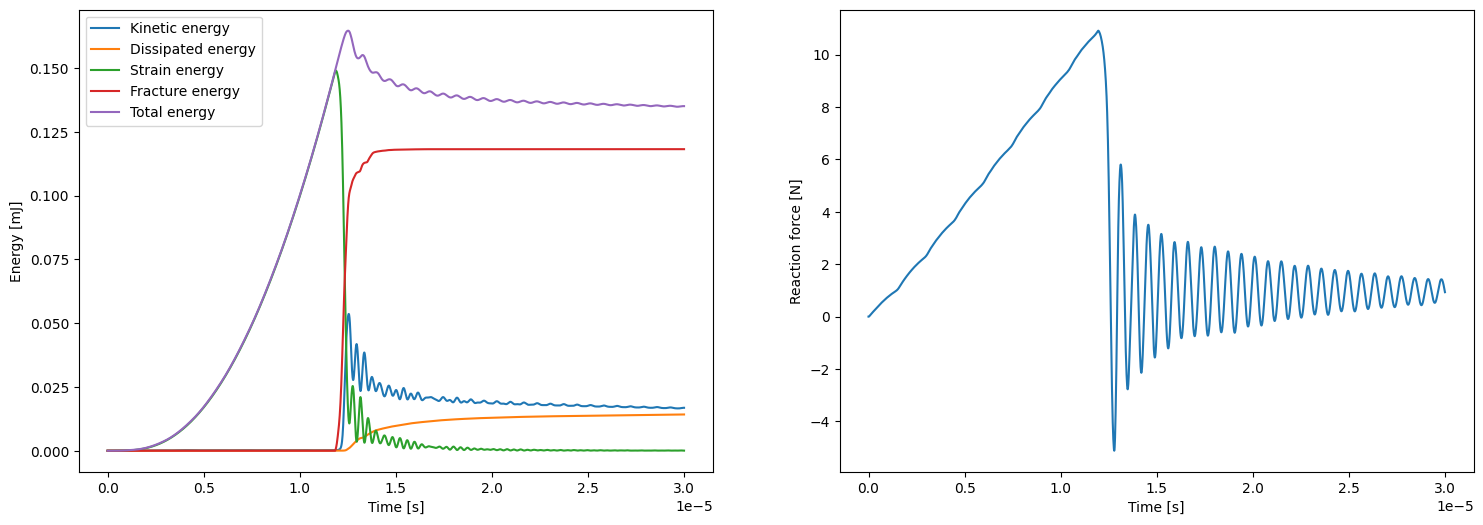

In [14]:
%%px

if comm.rank == 0:
    fig2, ax2 = plt.subplots(1, 2, figsize=(18,6))
    
    ax2[0].plot(ts, kinetic_energies, label='Kinetic energy')
    ax2[0].plot(ts, dissipated_energies, label='Dissipated energy')
    ax2[0].plot(ts, strain_energies, label='Strain energy')
    ax2[0].plot(ts, fracture_energies, label='Fracture energy')
    ax2[0].plot(ts, kinetic_energies + strain_energies + fracture_energies, label='Total energy')
    ax2[0].set_xlabel('Time [s]')
    ax2[0].set_ylabel('Energy [mJ]')
    ax2[0].legend()
    
    ax2[1].plot (ts, reaction_force_right_s)
    ax2[1].set_xlabel('Time [s]')
    ax2[1].set_ylabel('Reaction force [N]')
    plt.show()